In [1]:
import os
import os.path as osp
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from data.transform import RandomErasing
from data.datasets import get_dataset_cls
from data.sampler import BalancedBatchSampler

from model import resnet18_reid, resnet50_reid

## Define preprocessing piepline

In [2]:
te_transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    # For visualization reason
    # ==============================================
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
    ])

## Load Dataset

In [3]:
dataset_cls = get_dataset_cls('market1501')
dataset = dataset_cls(root="../download/", mode="all", transform=te_transform)

print(dataset)

[DukeMTMCreID]
| Source | Images | Pids | Camids |
| train  | 36411  | 1812 |   8    |
| query  |  2228  | 702  |   8    |
| gallery| 17661  | 1110 |   8    |



## Define Balance Sampler

In [4]:
P = 3
K = 3

labels = [ sample[1] for sample in dataset.data ]
sampler = BalancedBatchSampler(labels, P=P, K=K)
dataloader = DataLoader(dataset, batch_sampler=sampler)

## Load pretrain model

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PRETRAIN_MODEL = "../run/crossentropy/best.pth"
state_dict = torch.load(PRETRAIN_MODEL)

# Drop classifier layer
drop_keys = [ k for k, v in state_dict.items() if 'classifier' in k ]
for k in drop_keys:
    del state_dict[k]
    
model = resnet18_reid(features=128)
model.load_state_dict(state_dict, strict=False)
model = model.to(DEVICE)
model = model.eval()

## Compute cosine similarity

In [9]:
imgs, labels, camids, img_paths = next(iter(dataloader))
imgs = imgs.to(DEVICE)

embeddings = model(imgs)
scores = torch.mm(embeddings, torch.t(embeddings)).detach().cpu().numpy()

In [10]:
sort_indexes = np.argsort(scores)[:, ::-1]
print(sort_indexes)

[[0 2 1 6 7 4 8 3 5]
 [1 2 0 6 7 8 4 3 5]
 [2 1 0 6 7 8 4 3 5]
 [3 5 4 7 8 6 1 0 2]
 [4 5 3 8 7 6 0 1 2]
 [5 3 4 7 8 6 1 0 2]
 [6 7 8 3 1 2 5 4 0]
 [7 6 8 3 5 1 2 4 0]
 [8 6 7 3 5 4 1 2 0]]


## Show ranking result

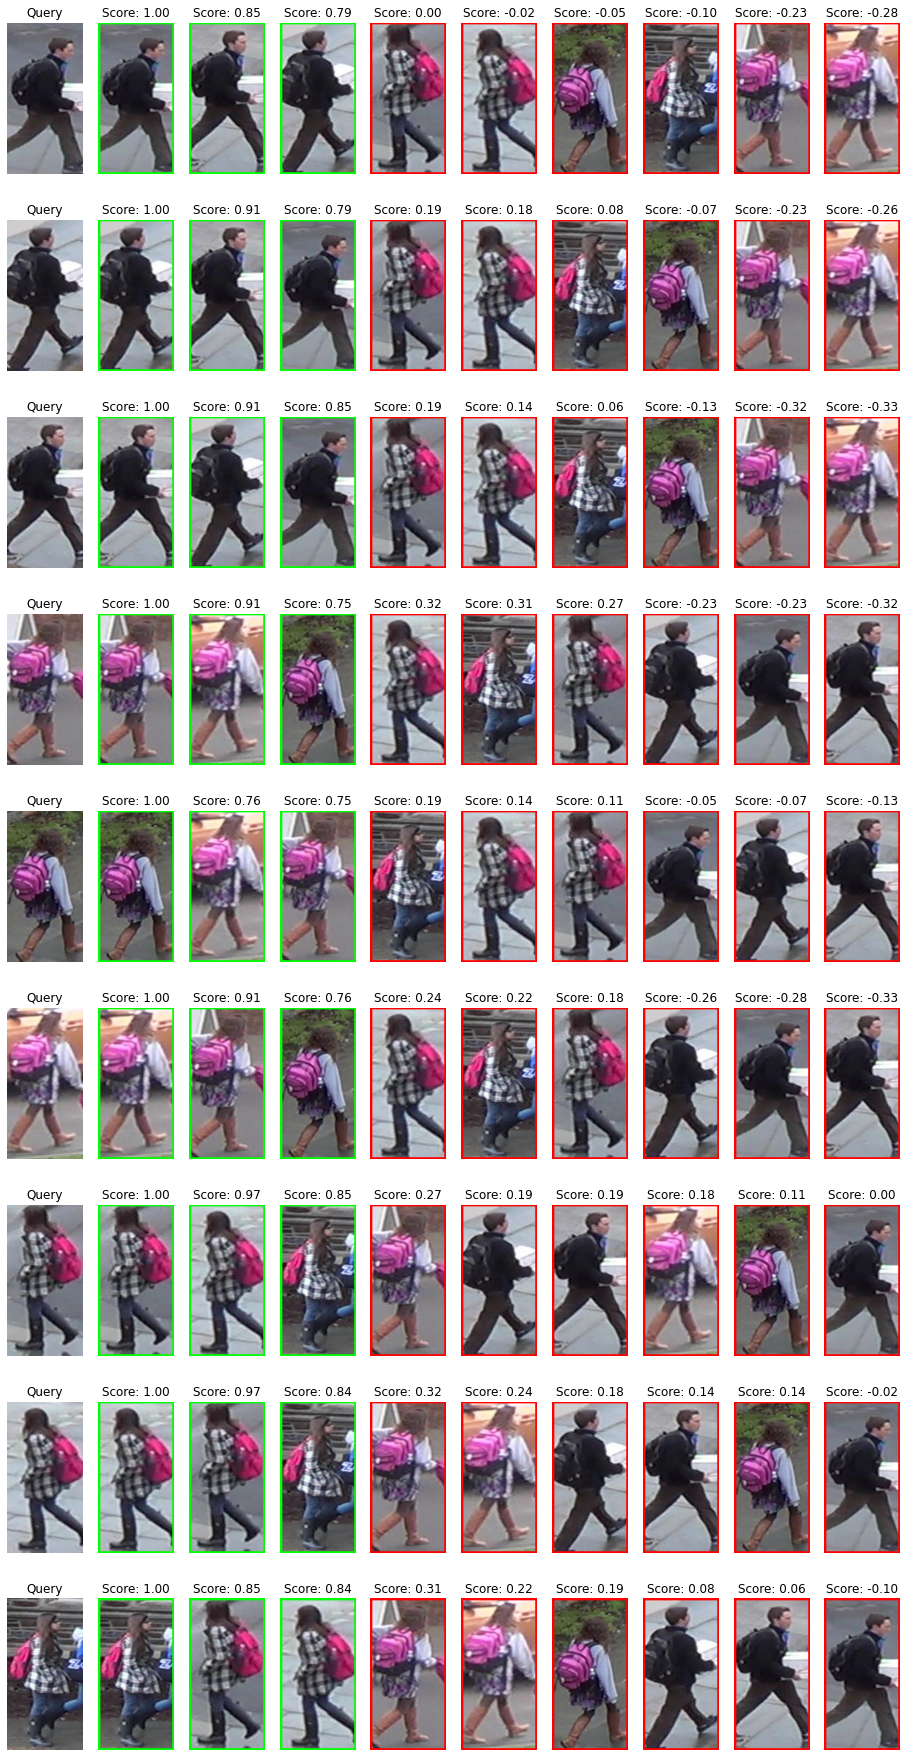

In [11]:
fig, axes = plt.subplots(nrows=P*K, ncols=P*K+1, figsize=(16, 32))

for i, query_index in enumerate(range(P*K)):
    for j, sample_index in enumerate(sort_indexes[query_index]):
        img = cv2.imread(img_paths[sample_index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 256))
        color = (255, 0, 0) if labels[sample_index] != labels[i] else (0, 255, 0)
        img = cv2.rectangle(img, (0,0), (128, 256), color=color, thickness=5)
        axes[i][j+1].imshow(img)
        axes[i][j+1].set_axis_off()
        axes[i][j+1].set_title("Score: {:.2f}".format(scores[i][sample_index]))
        
    img = cv2.imread(img_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 256))
    axes[i][0].imshow(img)
    axes[i][0].set_axis_off()
    axes[i][0].set_title("Query")